In [2]:
from pandas.core.indexes import datetimes
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import gurobipy as gp
import pandas as pd

# 1.
題目假設：  
製作 1 單位 product1 需要 1 單位 plant1 及 3 單位 plant 3  
製作 1 單位 product2 需要 2 單位 plant2 及 2 單位 plant 3  

## (a) Graphical solution by the “Concept of Dominance”

模型列式：  
maximun profit: $$Max: 3x_1 + 5x_2$$
minimun penalty: $$Min: 3x_1 + 4x_2$$


$s.t.$
$$x_1 ≤ 4$$
$$2x_2 ≤ 12$$
$$3x_1+2x_2 ≤ 18$$
$$x_1, x_2 ≥ 0$$


![IMG_0491B5EEB057-1.jpeg](attachment:8e9eb13d-ae23-4469-a7cb-63d4b8081910.jpeg)

#### model:
$$Max: W_1(3x_1+5x_2)-W_2(2x_1+4x_2)$$
$s.t.$
$$x_1 ≤ 4$$
$$2x_2 ≤ 12$$
$$3x_1+2x_2 ≤ 18$$
$$x_1, x_2 ≥ 0$$

In [3]:
data = pd.read_excel("ORA_Assignment_04_DEA.xlsx", header=0)

In [4]:
SCHOOLS = [item for item in data["School"] if isinstance(item, str)]

In [5]:
SCHOOL_DATA = {}
schools, deps = [], []
for index, row in data.iterrows():
    if isinstance(row["School"], str):
        school = row["School"]
        SCHOOL_DATA[school] = pd.DataFrame(data=None, columns=data.columns[1:])
    else:
        SCHOOL_DATA[school] = SCHOOL_DATA[school].append(pd.DataFrame(pd.DataFrame(data=row[1:]).T, columns=data.columns[1:]))
        schools.append(school)
        deps.append(row["Department"])

In [6]:
IDX = pd.MultiIndex.from_arrays([schools, deps], names=["School", "Department"])
collect = pd.concat([SCHOOL_DATA[school].iloc[:] for school in SCHOOLS]).drop(["Department"], axis=1)
VALUE_DATA = pd.DataFrame(data=np.array(collect), columns=collect.columns, index=IDX)
VALUE_DATA.head()

Personnel Expenses (unit:1000) Space Teaching  \
School       Department                                                        
Liberal Arts Chinese                33.5               6079.5  5376    26131   
             Foreign Languages      36.5               8387.4  4574    40105   
             History                  26               5104.8  3795    13678   
             Arts                      6               3420.6  1610     4926   
Sciences     Mathematics            29.5               6426.2  4175    23647   

                               Publications Grants (unit:1000)  
School       Department                                         
Liberal Arts Chinese                      5             4250.9  
             Foreign Languages            0             1543.5  
             History                      0             1729.1  
             Arts                         0             3562.2  
Sciences     Mathematics                 27            10518.6

In [7]:
I = 3
O = 3
INPUTS = [i for i in  data.columns[2:2+I]]
OUTPUTS = [o for o in  data.columns[2+I:2+I+O]]

In [8]:
for index, row in SCHOOL_DATA[SCHOOLS[0]].iterrows():
    print([row[i] for i in INPUTS])
    print()


[33.5, 6079.5, 5376.0]

[36.5, 8387.4, 4574.0]

[26.0, 5104.8, 3795.0]

[6.0, 3420.6, 1610.0]



In [9]:
DMU = []
X = {}
Y = {}
for s in SCHOOLS:
    for index, row in SCHOOL_DATA[s].iterrows():
        DMU = DMU + [row.iloc[0]]
        X[row.iloc[0]] = [i for i in row.iloc[1:4]]
        Y[row.iloc[0]] = [o for o in row.iloc[4:]]


In [74]:
record = {}  

## cal technical efficiency (VRS) and scale efficiency (CRS) for each DMU
for r in DMU:            
    
    ## VRS
    vrs_model=gp.Model("VRS_model")
    
    ## add variables
    vrs_v, vrs_u,u0={},{},{}
    for i in range(I):
        vrs_v[r,i]=vrs_model.addVar(vtype=gp.GRB.CONTINUOUS,name="%s"%(INPUTS[i]))
    
    for j in range(O):
        vrs_u[r,j]=vrs_model.addVar(vtype=gp.GRB.CONTINUOUS, name="%s"%(OUTPUTS[j]))
    u0[r]=vrs_model.addVar(lb=-1000,vtype=gp.GRB.CONTINUOUS, name="u_0")
    
    vrs_model.update()
    
    ## objective
    vrs_model.setObjective(gp.quicksum(vrs_u[r,j]*Y[r][j] for j in range(O))-u0[r],gp.GRB.MAXIMIZE)
    
    ## add constraints
    vrs_model.addConstr(gp.quicksum(vrs_v[r,i]*X[r][i] for i in range(I))==1)
    for k in DMU:
        vrs_model.addConstr(gp.quicksum(vrs_u[r,j]*Y[k][j] for j in range(O))-gp.quicksum(vrs_v[r,i]*X[k][i] for i in range(I))-u0[r] <=0)
    
    ## solve
    vrs_model.optimize()
    
    ## cal scale efficiency (CRS) for each dmu    
    crs_model=gp.Model("CRS_model")
    
    ## add variables
    crs_v, crs_u = {},{}
    for i in range(I):
        crs_v[r,i]=crs_model.addVar(vtype=gp.GRB.CONTINUOUS,name="v_%s%d"%(r,i))
    
    for j in range(O):
        crs_u[r,j]=crs_model.addVar(vtype=gp.GRB.CONTINUOUS,name="u_%s%d"%(r,j))
    
    crs_model.update()
    
    ## objective
    crs_model.setObjective(gp.quicksum(crs_u[r,j] * Y[r][j] for j in range(O)), gp.GRB.MAXIMIZE)
    
    ## add constraints
    crs_model.addConstr(gp.quicksum(crs_v[r,i] * X[r][i] for i in range(I)) == 1)
    for k in DMU:
        crs_model.addConstr(gp.quicksum(crs_u[r,j]*Y[k][j] for j in range(O)) - gp.quicksum(crs_v[r,i]*X[k][i] for i in range(I)) <= 0)
    
    ## solve
    crs_model.optimize()
    
    record[r] = np.round([v.x for v in vrs_model.getVars()] + [vrs_model.objVal] + [crs_model.objVal], 6)



Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 42 rows, 7 columns and 284 nonzeros
Model fingerprint: 0xd1a9ea3b
Coefficient statistics:
  Matrix range     [1e+00, 3e+05]
  Objective range  [1e+00, 3e+04]
  Bounds range     [1e+03, 1e+03]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.01s
Presolved: 42 rows, 7 columns, 284 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.1537676e+32   4.699710e+31   1.153768e+02      0s
       7    9.6828152e-01   0.000000e+00   0.000000e+00      0s

Solved in 7 iterations and 0.01 seconds
Optimal objective  9.682815161e-01
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 42 rows, 6 columns and 243 nonzeros
Model fingerprint: 0x4574a645
Coefficient statistics:
  Matrix range     [1e+00, 3e+05]
  Objectiv

In [75]:
def judge_RS(u0):
    if u0 > 0:
        return "DRS"
    elif u0 < 0:
        return "IRS"
    return "CRS"


In [91]:
col = [v.varName for v in vrs_model.getVars()] + ["TE", "OE"]
result = pd.DataFrame(data=record).T
result.columns = col
result["SE"] = np.round(result["OE"] / result["TE"], 3)
result["return to scale"] = [judge_RS(u0=u0) for u0 in result["u_0"]]
result = result.set_index(keys=IDX)
result

Personnel  Expenses (unit:1000)  \
School          Department                                              
Liberal Arts    Chinese                0.000000              0.000164   
                Foreign Languages      0.000000              0.000000   
                History                0.000000              0.000196   
                Arts                   0.164011              0.000000   
Sciences        Mathematics            0.000000              0.000141   
                Physics                0.000000              0.000096   
                Chemistry              0.028413              0.000000   
                Earth Sciences         0.046929              0.000020   
                Biology                0.051698              0.000006   
                Biotechnology          0.000000              0.000000   
Engineering     Mechanical Eng.        0.000000              0.000070   
                Electrical Eng.        0.017606              0.000000   
                Information Eng.       0.055340              0.000000   
                Chemical Eng.          0.008617              0.000054   
                Resources Eng.         0.026376              0.000057   
                Materials Eng.         0.038462              0.000000   
                Civil Eng.             0.028214              0.000001   
                Hydraulic Eng.         0.036364              0.000000   
                Architecture           0.035088              0.000000   
                Engineering Science    0.036805              0.000000   
                Naval Architecture     0.035657              0.000053   
                Urban Planning         0.055049              0.000005   
                Industrial Design      0.080000              0.000000   
                Aeronautical Eng.      0.000000              0.000115   
                Environmental Eng.     0.049811              0.000000   
                Surveying Eng.         0.045606              0.000036   
                Manufacturing Eng.     0.119548              0.000000   
                Biomedical Eng.        0.100000              0.000000   
Management      Industrial Mgmt.       0.018578              0.000068   
                Transportation Mgmt.   0.030573              0.000073   
                Business Admin.        0.029031              0.000000   
                Accountancy            0.066667              0.000000   
                Statistics             0.000000              0.000239   
Medicine        Medicine               0.000000              0.000025   
                Nursing                0.008559              0.000000   
                Medical Technology     0.000000              0.000050   
                Occupational Therapy   0.054852              0.000154   
                Physical Therapy       0.048211              0.000152   
Social Sciences Political Economy      0.000000              0.000000   
                Education              0.000000              0.000548   
                Law                    0.000000              0.000000   

                                         Space  Teaching  Publications  \
School          Department                                               
Liberal Arts    Chinese               0.000000  0.000032      0.006843   
                Foreign Languages     0.000219  0.000424      0.000000   
                History               0.000000  0.000034      0.000000   
                Arts                  0.000010  0.000131      0.000000   
Sciences        Mathematics           0.000022  0.000033      0.009524   
                Physics               0.000013  0.000022      0.006270   
                Chemistry             0.000008  0.000026      0.003606   
                Earth Sciences        0.000031  0.000044      0.001109   
                Biology               0.000000  0.000042      0.001159   
                Biotechnology         0.000856  0.000000      0.000000   
Engineerin

In [77]:
result.to_csv("DEA_result.csv", float_format='%.6f')

In [10]:
result_read = (pd.read_csv("DEA_result.csv", index_col=0))
result_read = pd.DataFrame(data=np.array(result_read), columns=result_read.columns, index=IDX)
result_read.head()

Department Personnel  \
School       Department                                       
Liberal Arts Chinese                      Chinese         0   
             Foreign Languages  Foreign Languages         0   
             History                      History         0   
             Arts                            Arts  0.164011   
Sciences     Mathematics              Mathematics         0   

                               Expenses (unit:1000)     Space  Teaching  \
School       Department                                                   
Liberal Arts Chinese                       0.000164         0   3.2e-05   
             Foreign Languages                    0  0.000219  0.000424   
             History                       0.000196         0   3.4e-05   
             Arts                                 0     1e-05  0.000131   
Sciences     Mathematics                   0.000141   2.2e-05   3.3e-05   

                               Publications Grants (unit:1000)       u_0  \
School       Department                                                    
Liberal Arts Chinese               0.006843                  0   -0.1009   
             Foreign Languages            0                  0   16.0008   
             History                      0                  0 -0.190536   
             Arts                         0                  0 -0.355262   
Sciences     Mathematics           0.009524                  0  0.037731   

                                      TE        OE     SE return to scale  
School       Department                                                    
Liberal Arts Chinese            0.968282  0.935939  0.967             IRS  
             Foreign Languages         1         1      1             DRS  
             History            0.660915  0.567983  0.859             IRS  
             Arts                      1  0.770042   0.77             IRS  
Sciences     Mathematics               1         1      1             DRS

In [10]:

## 3D plotting
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
from numpy.random import rand
from pylab import figure

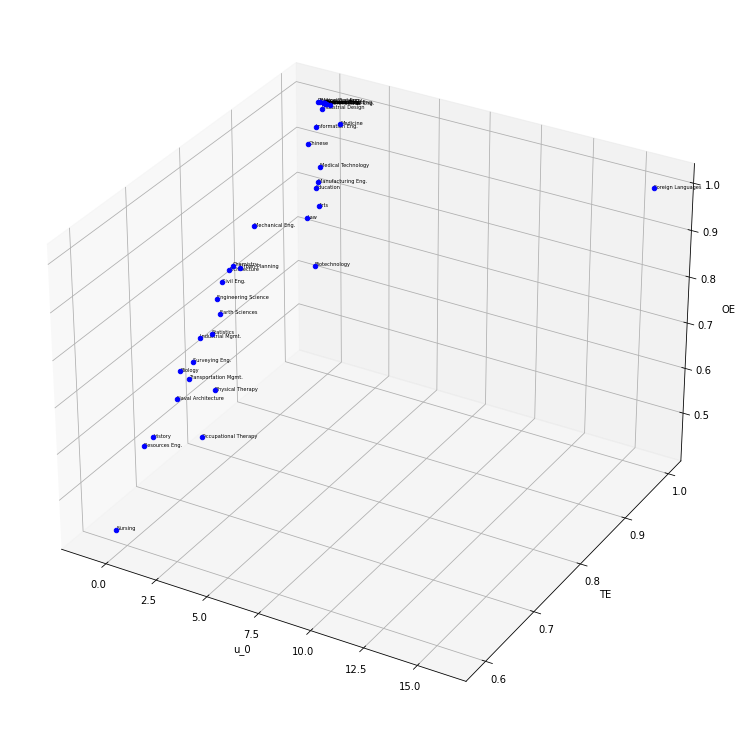

In [11]:
plot_data = pd.DataFrame(data=result_read["u_0"])
plot_data["TE"] = list(result_read["TE"])
plot_data["OE"] = list(result_read["OE"])

m = np.array(plot_data)# m is an array of (x,y,z) coordinate triplets

fig = figure(figsize=(10, 20))
ax = Axes3D(fig)

dot_name = deps

for i in range(len(m)): #plot each point + it's index as text above
 ax.scatter(m[i,0],m[i,1],m[i,2], color='b') 
 ax.text(m[i,0],m[i,1],m[i,2], '%s' % (dot_name[i]), size=5, zorder=1, color='k') 

ax.set_zlabel('OE')
ax.set_ylabel('TE')
ax.set_xlabel('u_0')
pyplot.show()

In [12]:
## find efficient point
best = pd.DataFrame(columns=result_read.columns)
for index, row in result_read.iterrows():
    if row["TE"] == 1:
        if row["OE"] == 1:
            best = best.append(row)
best

,Department,Personnel,Expenses (unit:1000),Space,Teaching,Publications,Grants (unit:1000),u_0,TE,OE,SE,return to scale
"(Liberal Arts, Foreign Languages)",Foreign Languages,0.000000,0.000000,0.000219,0.000424,0.000000,0.000000,16.000831,1.0,1.0,1.0,DRS
"(Sciences, Mathematics)",Mathematics,0.000000,0.000141,0.000022,0.000033,0.009524,0.000000,0.037731,1.0,1.0,1.0,DRS
"(Sciences, Physics)",Physics,0.000000,0.000096,0.000013,0.000022,0.006270,0.000000,0.021376,1.0,1.0,1.0,DRS
"(Engineering, Electrical Eng.)",Electrical Eng.,0.017606,0.000000,0.000000,0.000016,0.000000,0.000002,0.027833,1.0,1.0,1.0,DRS
"(Engineering, Chemical Eng.)",Chemical Eng.,0.008617,0.000054,0.000000,0.000015,0.004014,0.000000,-0.075069,1.0,1.0,1.0,IRS
"(Engineering, Materials Eng.)",Materials Eng.,0.038462,0.000000,0.000000,0.000030,0.000951,0.000004,-0.060398,1.0,1.0,1.0,IRS
"(Engineering, Hydraulic Eng.)",Hydraulic Eng.,0.036364,0.000000,0.000000,0.000000,0.000000,0.000006,-0.082979,1.0,1.0,1.0,IRS
"(Engineering, Aeronautical Eng.)",Aeronautical Eng.,0.000000,0.000115,0.000000,0.000008,0.008356,0.000003,0.225161,1.0,1.0,1.0,DRS
"(Engineering, Environmental Eng.)",Environmental Eng.,0.049811,0.000000,0.000015,0.000000,0.005173,0.000008,-0.065168,1.0,1.0,1.0,IRS
"(Engineering, Biomedical Eng.)",Biomedical Eng.,0.100000,0.000000,0.000000,0.000000,0.018800,0.000000,-0.304400,1.0,1.0,1.0,IRS


In [13]:
best.index[0][1]

'Foreign Languages'

In [14]:
def get_value_df(df):
    df_copy = df.copy()
    for dep in range(len(df_copy.index)):
        for i in range(3):
            df_copy.iloc[dep, i] = X[df_copy.index[dep][1]][i]
            df_copy.iloc[dep, i+3] = Y[df_copy.index[dep][1]][i]
    return df_copy

In [17]:
best_value = get_value_df(best)
best_value

,Department,Personnel,Expenses (unit:1000),Space,Teaching,Publications,Grants (unit:1000),u_0,TE,OE,SE,return to scale
"(Liberal Arts, Foreign Languages)",36.5,8387.4,4574.0,40105.0,0.0,1543.5,0.000000,16.000831,1.0,1.0,1.0,DRS
"(Sciences, Mathematics)",29.5,6426.2,4175.0,23647.0,27.0,10518.6,0.000000,0.037731,1.0,1.0,1.0,DRS
"(Sciences, Physics)",44.8,9360.1,8184.0,27613.0,66.0,60912.4,0.000000,0.021376,1.0,1.0,1.0,DRS
"(Engineering, Electrical Eng.)",56.8,17607.4,25770.0,46582.0,161.0,160768.2,0.000002,0.027833,1.0,1.0,1.0,DRS
"(Engineering, Chemical Eng.)",46,11161.6,27410.0,28664.0,120.0,58183.2,0.000000,-0.075069,1.0,1.0,1.0,IRS
"(Engineering, Materials Eng.)",26,8975.2,6326.0,16284.0,95.3,101281.4,0.000004,-0.060398,1.0,1.0,1.0,IRS
"(Engineering, Hydraulic Eng.)",27.5,8506.4,9435.0,13059.0,17.5,165046.9,0.000006,-0.082979,1.0,1.0,1.0,IRS
"(Engineering, Aeronautical Eng.)",57.5,8718.2,12550.0,18029.0,70.0,153755.8,0.000003,0.225161,1.0,1.0,1.0,DRS
"(Engineering, Environmental Eng.)",19,6593.6,3548.0,8609.0,35.0,91704.7,0.000008,-0.065168,1.0,1.0,1.0,IRS
"(Engineering, Biomedical Eng.)",10,4490.1,3937.0,6263.0,37.0,28470.8,0.000000,-0.304400,1.0,1.0,1.0,IRS


In [18]:
## worst
temp = 1
for index, row in result_read.iterrows():
    if row["TE"] < temp:
        worst = row.copy()
        temp = row["TE"]
worst

Department               Nursing
Personnel               0.008559
Expenses (unit:1000)           0
Space                   0.000393
Teaching                 3.3e-05
Publications            0.020007
Grants (unit:1000)             0
u_0                    -0.267515
TE                      0.590562
OE                      0.433198
SE                         0.734
return to scale              IRS
Name: (Medicine, Nursing), dtype: object

In [19]:
## worst data
VALUE_DATA.loc[worst.name]

Personnel                   17
Expenses (unit:1000)    5212.2
Space                     2175
Teaching                  6500
Publications               5.5
Grants (unit:1000)      5399.1
Name: (Medicine, Nursing), dtype: object

In [12]:
schools_unique = []
for s in schools:
    if s not in schools_unique:
        schools_unique.append(s)
schools_unique

['Liberal Arts',
 'Sciences',
 'Engineering',
 'Management',
 'Medicine',
 'Social Sciences']

In [13]:
## split by school
COL_avg = ["Personnel_avg", "Expenses_avg", "Space_avg", "Teaching_avg", "Publications_avg", "Grants_avg", "TE_avg", "OE_avg", "SE_avg", "u_0_avg"]
schools_e = pd.DataFrame(columns=COL_avg)
for school in schools_unique:
    schools_e = schools_e.append(pd.DataFrame(data=[[
        np.mean(np.array(VALUE_DATA["Personnel"][school])), 
        np.mean(np.array(VALUE_DATA["Expenses (unit:1000)"][school])), 
        np.mean(np.array(VALUE_DATA["Space"][school])), 
        np.mean(np.array(VALUE_DATA["Teaching"][school])), 
        np.mean(np.array(VALUE_DATA["Publications"][school])), 
        np.mean(np.array(VALUE_DATA["Grants (unit:1000)"][school])), 
        np.mean(np.array(result_read["TE"][school])), 
        np.mean(np.array(result_read["OE"][school])), 
        np.mean(np.array(result_read["SE"][school])), 
        np.mean(np.array(result_read["u_0"][school]))
        ]], columns=COL_avg, index=[school]))
schools_e

,Personnel_avg,Expenses_avg,Space_avg,Teaching_avg,Publications_avg,Grants_avg,TE_avg,OE_avg,SE_avg,u_0_avg
Liberal Arts,25.500000,5748.075000,3838.750000,21210.000000,1.250000,2771.425000,0.907299,0.818491,0.899000,3.838533
Sciences,24.350000,7003.466667,5542.833333,16011.666667,29.000000,31141.316667,0.885792,0.803450,0.911000,-0.141366
Engineering,27.800000,8831.111111,10610.388889,17244.277778,44.044444,66090.844444,0.896248,0.866121,0.962778,-0.097990
Management,21.680000,5843.740000,4831.200000,17156.200000,8.000000,14985.300000,0.850908,0.804455,0.938200,-0.117738
Medicine,51.260000,10995.060000,7474.000000,14315.400000,92.800000,66535.700000,0.832961,0.647528,0.760600,-0.276082
Social Sciences,11.833333,2726.666667,1306.333333,9265.666667,2.166667,4076.233333,1.000000,0.848250,0.848333,-0.640522


In [76]:
pd.DataFrame(data=[[
        np.mean(np.array(VALUE_DATA["Personnel"][school])), 
        np.mean(np.array(VALUE_DATA["Expenses (unit:1000)"][school])), 
        np.mean(np.array(VALUE_DATA["Space"][school])), 
        np.mean(np.array(VALUE_DATA["Teaching"][school])), 
        np.mean(np.array(VALUE_DATA["Publications"][school])), 
        np.mean(np.array(VALUE_DATA["Grants (unit:1000)"][school])), 
        np.mean(np.array(result_read["TE"][school])), 
        np.mean(np.array(result_read["OE"][school])), 
        np.mean(np.array(result_read["SE"][school])), 
        ]])

,0,1,2,3,4,5,6,7,8
0,25.5,5748.075,3838.75,21210.0,1.25,2771.425,0.907299,0.818491,0.899


In [71]:
np.mean(np.array(VALUE_DATA["Personnel"][school]))

11.833333333333334

In [69]:
temp = pd.DataFrame(columns=["A", "B"])
temp = temp.append(pd.DataFrame([[1, 2]], columns=["A", "B"], index=["D"]))
temp

,A,B
D,1,2


In [46]:
[result_read["TE"][school] for school in schools_unique]

Department
Mathematics              1
Physics                  1
Chemistry         0.811823
Earth Sciences    0.791274
Biology           0.711658
Biotechnology            1
Name: TE, dtype: object

In [28]:
np.array(result_read["TE"]["Liberal Arts"])

array([0.968282, 1.0, 0.6609149999999999, 1.0], dtype=object)